In [1]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  
import os
import pandas as pd
from copy import deepcopy

import torch
import torch.nn as nn

# import torch

/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
geo_file = "data/los_angeles_censustracts.json"
time_file = "data/los_angeles-censustracts-2020-1-All-MonthlyAggregate.csv"
os.makedirs ("./figs", exist_ok=True)

In [3]:
with open(geo_file) as geojson:
    census_tracts = json.loads(geojson.readline())

In [4]:
names = dict()
coordinates = dict()


for feat in census_tracts['features']:
    id = int(feat['properties']['MOVEMENT_ID'])
    name_ = feat['properties']['DISPLAY_NAME']
    names[id] = name_
    a = feat['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [5]:
g = Graph(directed=False)
g.add_vertices(len(names))
g.vs['display_name'] = list(names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [6]:
month_filter = 1

edges = []
weights = []

with open(time_file) as f:
    f.readline()  # skip the first line
    while True:
        line = f.readline()
        if not line or line == '':
            break
    
        line = line.strip().split(',')
        src, dest, month, dist = int(line[0]), int(line[1]), int(line[2]), float(line[3])


        if month == month_filter:

            edges.append((src - 1, dest - 1))
            weights.append(dist)

In [7]:
g.add_edges(edges)
g.es['weight'] = weights
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [8]:
print(len(g.vs), len(g.es))

2650 932672


In [9]:
# g = road_map
edges = np.array(g.get_edgelist())
node_features = np.array(g.vs["coordinates"])
edge_weights = np.array(g.es["weight"])

In [10]:
 from torch.nn import Linear
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from sklearn.model_selection import KFold
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch_geometric.data import Data

In [18]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

device = 'cuda' if torch.cuda.is_available() else "cpu"

## Baseline

In [12]:
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean
data = data.cpu()
distances = [euclidean(data.x[edge[0]].numpy(), data.x[edge[1]].numpy()) for edge in data.edge_index.t().numpy()]
distances = torch.tensor(distances, dtype=torch.float32).view(-1, 1)

scale_factor = data.edge_attr.sum() / distances.sum()

predicted_weights = distances * scale_factor

mse = mean_squared_error(data.edge_attr.numpy(), predicted_weights.numpy())
print(f'Overall MSE: {mse}')


Overall MSE: 311659.46875


## GCN

In [22]:

def train_model_and_plot(model, data, epochs = 200, title = "",  save_path = None ):
    optimizer = AdamW(model.parameters(), lr=0.01)
    criterion = MSELoss()

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    losses = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(data.edge_index.t())):
        train_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
        train_mask[train_idx] = True
        test_mask = torch.zeros(data.edge_index.size(1), dtype=bool)
        test_mask[test_idx] = True

        fold_train_losses = []
        fold_test_losses = []
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data, data.edge_index[:, train_mask])
            loss = criterion(out.float(), data.edge_attr[train_mask].float())
            loss.backward()
            optimizer.step()

            fold_train_losses.append(loss.item())
            
            model.eval()
            with torch.no_grad():
                pred = model(data, data.edge_index[:, test_mask])
                test_loss = criterion(pred.float(), data.edge_attr[test_mask].float())
            
            fold_test_losses.append(test_loss.item())

        losses.append((fold_train_losses, fold_test_losses))
        print(f'Fold {fold}, Test loss: {test_loss.item()}')

    # loss curve of first fold
    train_losses, test_losses = losses[0]
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    if save_path is not None:
        plt.savefig(os.path.join("./figs", save_path))

In [23]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        
        self.node_encoder = GCNConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        # x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        # print(edge_index.shape)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)



Fold 0, Test loss: 408433.65625
Fold 1, Test loss: 406919.40625
Fold 2, Test loss: 405797.875
Fold 3, Test loss: 405354.09375
Fold 4, Test loss: 398720.15625


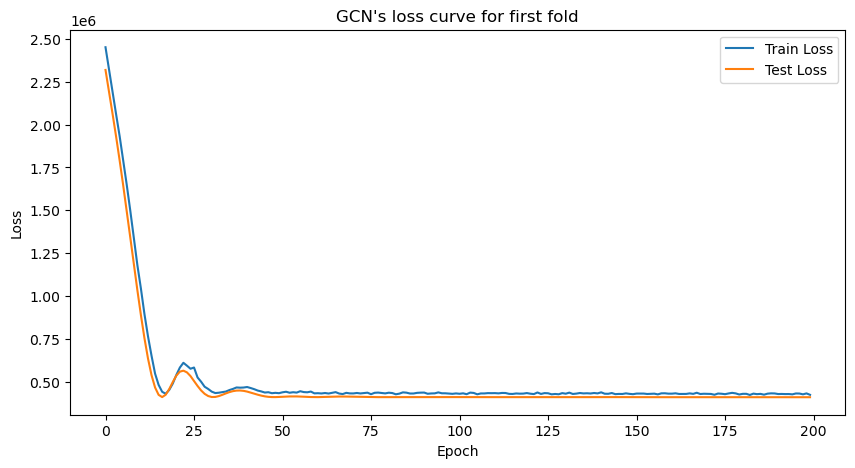

In [24]:
num_node_features = node_features.shape[1]
model = GCN(num_node_features, hidden_channels=128)

train_model_and_plot(model.to(device), data.to(device), 
                     epochs = 200, 
                     title = "GCN's loss curve for first fold",
                     save_path = "gcn_results.png" )

In [25]:
from torch_geometric.nn import SAGEConv
class SAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(SAGE, self).__init__()
        self.node_encoder = SAGEConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)

Fold 0, Test loss: 395533.78125
Fold 1, Test loss: 395897.40625
Fold 2, Test loss: 396312.9375
Fold 3, Test loss: 397937.9375
Fold 4, Test loss: 399089.3125


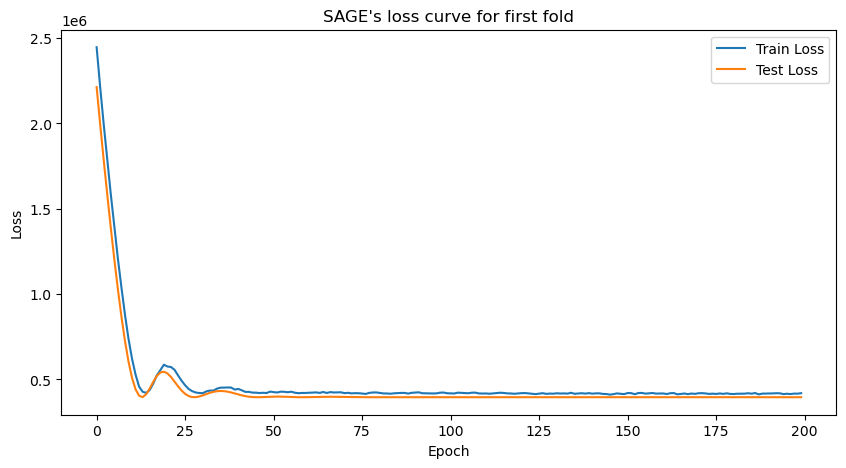

In [26]:
num_node_features = node_features.shape[1]
model = SAGE(num_node_features, hidden_channels=128)

train_model_and_plot(model.to(device), data.to(device), 
                     epochs = 200, 
                     title = "SAGE's loss curve for first fold",
                     save_path = "sage_results.png" )

In [27]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GAT, self).__init__()
        self.node_encoder = GATConv(num_node_features, hidden_channels)
        self.edge_predictor = Linear(2*hidden_channels, 1)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        return self.edge_predictor(edge_features)


Fold 0, Test loss: 395468.53125
Fold 1, Test loss: 395678.3125
Fold 2, Test loss: 395885.4375
Fold 3, Test loss: 397788.59375
Fold 4, Test loss: 398921.84375


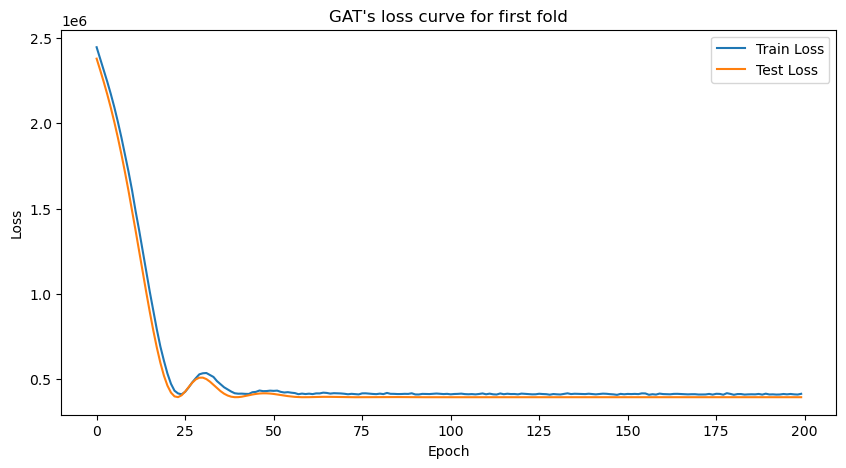

In [28]:
num_node_features = node_features.shape[1]
model = GAT(num_node_features, hidden_channels=128)

train_model_and_plot(model.to(device), data.to(device), 
                     epochs = 200, 
                     title = "GAT's loss curve for first fold",
                     save_path = "GAT_results.png" )

In [29]:
degree = np.array(g.degree())
node_features = np.hstack((node_features, degree.reshape(-1, 1)))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(node_features, dtype=torch.float)
edge_attr = torch.tensor(edge_weights, dtype=torch.float).view(-1, 1)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

Fold 0, Test loss: 371051.59375
Fold 1, Test loss: 369154.5625
Fold 2, Test loss: 368328.125
Fold 3, Test loss: 372524.0
Fold 4, Test loss: 369312.8125


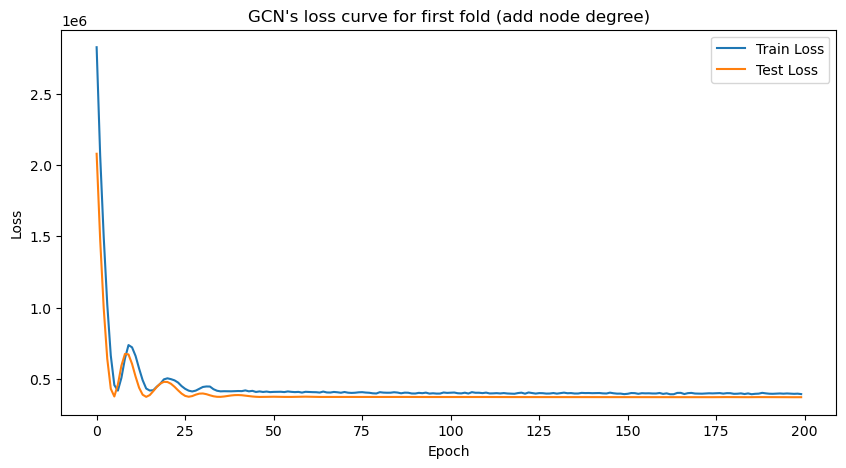

In [30]:
num_node_features = node_features.shape[1]
model = GCN(num_node_features, hidden_channels=128)

train_model_and_plot(model.to(device), data.to(device), 
                     epochs = 200, 
                     title = "GCN's loss curve for first fold (add node degree)",
                     save_path = "gcn_results_with_degree.png" )